In [1]:
import seaborn as sns
import pandas as pd

summ = pd.read_csv('summary_table_v1.4.csv')
raw = pd.read_csv('drugcomb_data_v1.4.csv')

block_to_study = raw[['block_id', 'study_name']].drop_duplicates()
summ = summ.merge(block_to_study, on='block_id')

mono = summ[summ['drug_col'].isna()]
comb = summ[~summ['drug_col'].isna()]

alm_raw = raw[raw['study_name'] == 'ALMANAC']

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [221]:
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt
import sys

def get_idx_to_mean_css_df(mono_df, drug_df, css_thresh=None, top_k=None):
    copy_mono_df = mono_df
    copy_drug_df = drug_df
    
    # Check that we're not trying to threshold and take top k
    assert not (css_thresh is not None and top_k is not None)
    
    if top_k is not None:
        copy_drug_df = copy_drug_df.sort_values('css', ascending=False).iloc[:top_k] 
        
    if css_thresh is not None:
        copy_drug_df = copy_drug_df[copy_drug_df['css'] > css_thresh]
        
    drug_names = copy_drug_df['drug_row'].drop_duplicates()
    copy_mono_df = copy_mono_df[copy_mono_df['drug_row'].isin(drug_names)]
        
    return copy_mono_df.groupby(['drug_idx', 'cell_line_idx'])['css'].mean().reset_index()

def get_plotting_df(mono_df, drug_df, css_thresh=None, top_k=None):
    df = get_idx_to_mean_css_df(mono_df, drug_df, css_thresh, top_k)
    X_plot = np.linspace(-30, 100, 130 * 3)

    to_append = []
    result = pd.DataFrame(columns=['drug_idx', 'samp_css_score', 'samp_css_density'])
    for drug_idx, group in tqdm(df.groupby('drug_idx')):
        kde = KernelDensity().fit(group['css'].values.reshape(-1, 1))
        log_density = kde.score_samples(X_plot.reshape(-1, 1))
        
        tmp_df = pd.DataFrame()
        tmp_df['drug_idx'] = np.full(log_density.shape[0], drug_idx)
        tmp_df['samp_css_score'] = X_plot
        tmp_df['samp_css_density'] = np.minimum(.07, np.exp(log_density))
        
        to_append.append(tmp_df)
    
    result = result.append(to_append)
    return result

def plot(plotting_df, angle=None, fname='', plot_mode='surf', use_log=False):    
    assert plot_mode in ['surf', 'scatter']
    
    fig = plt.figure(figsize=(14, 9))
    ax = fig.gca(projection='3d')
    
    cm = plt.cm.viridis if plot_mode == 'surf' else None
    fxn_name = 'plot_trisurf' if plot_mode == 'surf' else 'scatter'
    getattr(ax, fxn_name)(plotting_df['conc_r'], plotting_df['conc_c'], plotting_df['inhibition'], 
                          cmap=cm, linewidth=.02)
    
    ax.set_xlabel('First Drug Concentration (uM)')
    ax.set_ylabel('Second Drug Concentration (uM)')
    ax.set_zlabel('Percent Inhibition')
    
    if use_log:
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
    
    if angle is not None:
        ax.view_init(30, angle)
        
    title_str = '%s'
    inner_str = ''
    plt.title(title_str % inner_str)
    
    if fname != '':
        plt.savefig('%s.png' % fname)
    
    plt.show()
    
def _linearly_interpolate_coords(x, y, interp):
    result = []
    
    xy_list = [x, y]
    for i in [0, 1]:
        orig_coords = xy_list[i]

        idxs = contour[:, i].astype(np.int)
        fractionals = contour[:, i] - idxs

        diff_idx_arr = np.array(list(range(1, orig_coords.shape[0])) + [orig_coords.shape[0] - 1])
        orig_coords_diff = orig_coords[diff_idx_arr] - orig_coords

        # Linearly interpolate
        result.append(orig_coords[idxs] + (orig_coords_diff[idxs] * fractionals))
        
    X_IDX = 0
    Y_IDX = 1
    return result[X_IDX], result[Y_IDX]

def _apply_log(*args):
    res = []
    for arg in args:
        res.append(np.log(arg + sys.float_info.epsilon))
        
    return res

def plot_contour(block_id, level=50, apply_log=False, fname=''):
    cols = ['conc_r', 'conc_c', 'inhibition']
    pivoted_df = alm_raw[alm_raw['block_id'] == block_id][cols].pivot(*cols)
    
    x = pivoted_df.columns.values
    y = pivoted_df.index.values
    Z = pivoted_df.values
    
    # Len of contours is 0 if there aren't inhibition values above 50
    contours = measure.find_contours(Z, level)
    if len(contours) != 1:
        return
    
    fig, ax = plt.subplots()
    xx, yy = _linearly_interpolate_coords(x, y, contours[0])
    
    block_comb = comb[comb['block_id'] == block_id]
    ic50s = np.array([[0, block_comb['ic50_row'].item()], [block_comb['ic50_col'].item(), 0]])
    
    if apply_log:
        xx, yy, ic50s = _apply_log(xx, yy, ic50s)

    ax = sns.lineplot(x=xx, y=yy)
    ax.scatter(x=ic50s[:, 0], y=ic50s[:,1], color='orange')
    
    unit_str = 'log(uM)' if apply_log else 'uM'
    drug_row = block_comb['drug_row'].item()
    drug_col = block_comb['drug_col'].item()
    cell_line = block_comb['cell_line_name'].item()
    
    plt.xlabel('%s Concentration (%s)' % (drug_row, unit_str))
    plt.ylabel('%s Concentration (%s)' % (drug_col, unit_str))
    plt.title('Concentration Required for %d%% Inhibition for Pair %s and %s on %s' % (level, drug_row, drug_col, cell_line))

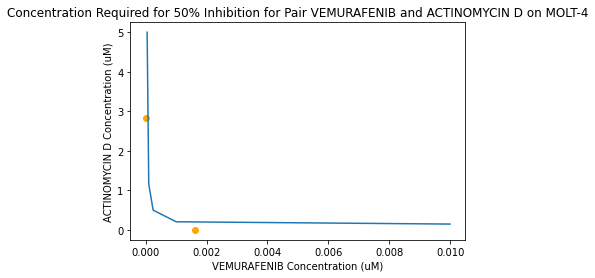

In [193]:
plot_contour(359467)

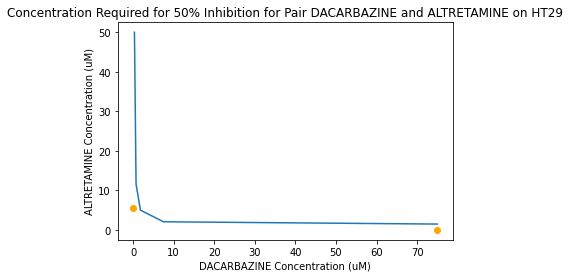

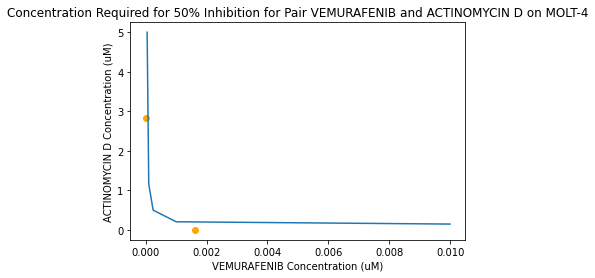

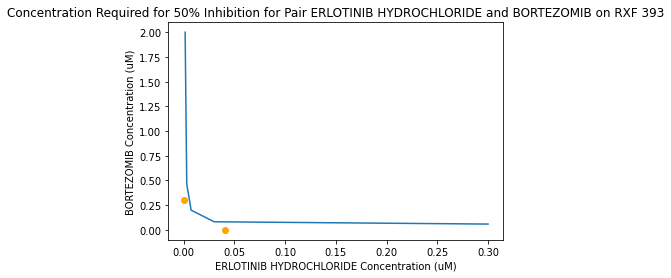

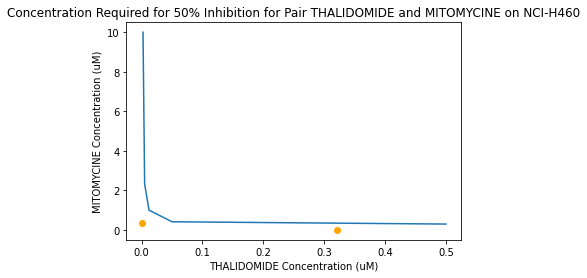

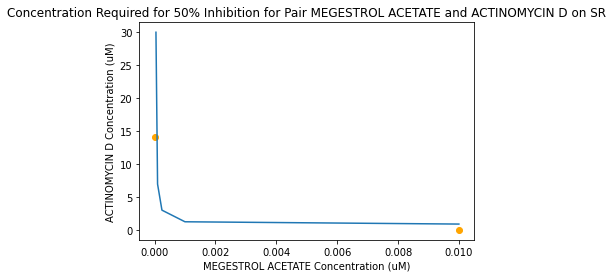

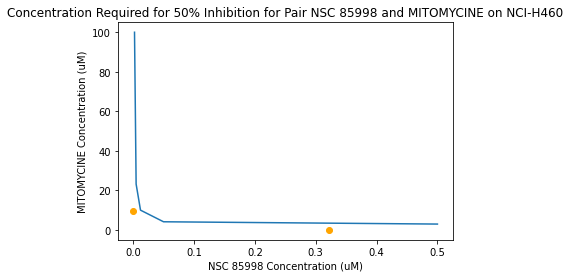

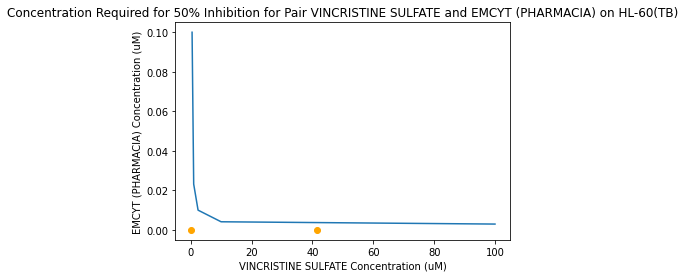

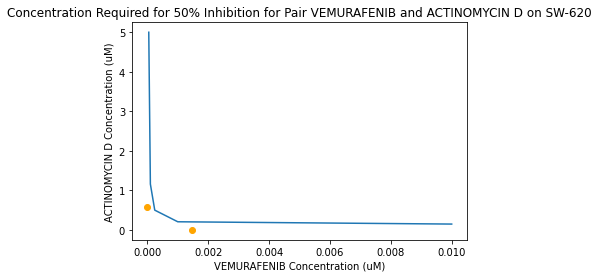

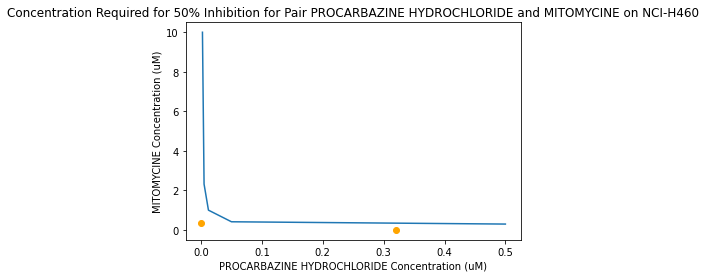

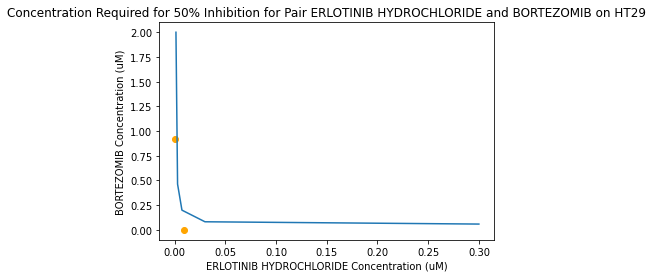

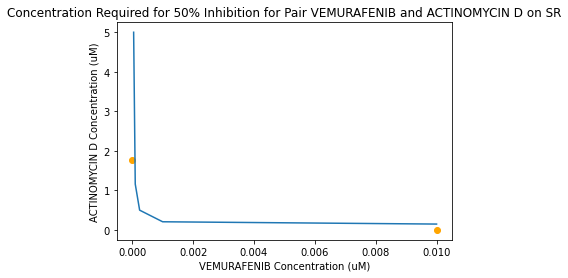

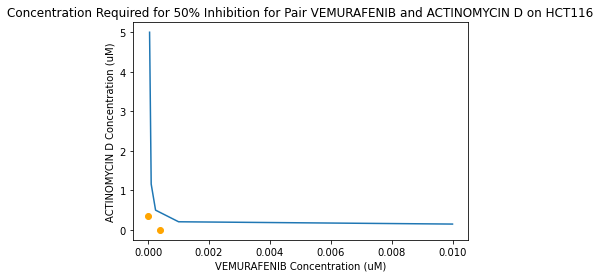

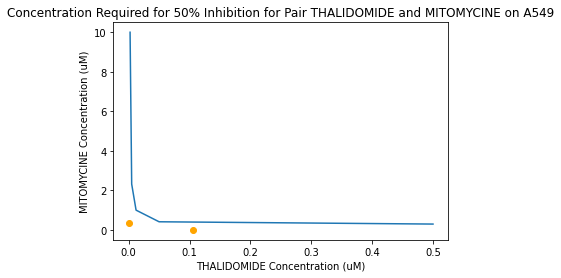

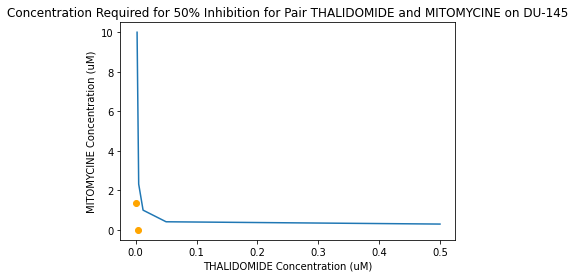

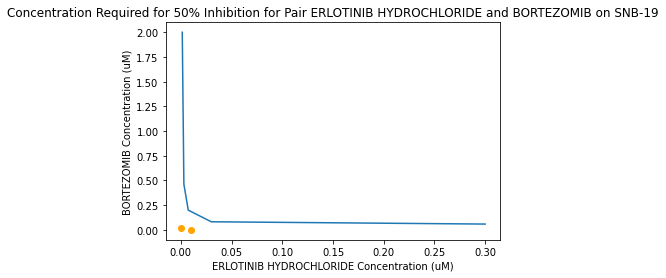

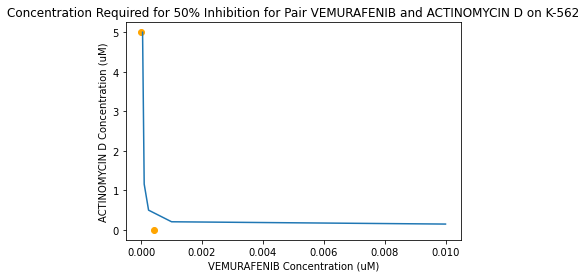

In [194]:
best_synergy_df = comb[comb['study_name'] == 'ALMANAC'].sort_values('synergy_zip', ascending=False).iloc[:20]
for block_id in best_synergy_df['block_id']:
    plot_contour(block_id)

In [52]:
alm_raw[alm_raw['block_id'] == 359467]

,block_id,conc_r,conc_c,inhibition,drug_row,drug_col,conc_r_unit,conc_c_unit,cell_line_name,drug_row_cid,drug_col_cid,cellosaurus_accession,study_name
6099432,359467,0.00,0.0000,-0.000626,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099433,359467,0.00,0.0001,-0.049670,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099434,359467,0.00,0.0010,0.565576,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099435,359467,0.00,0.0100,8.084379,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099436,359467,0.05,0.0000,-1.494316,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099437,359467,0.05,0.0001,9.619180,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099438,359467,0.05,0.0010,41.947695,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099439,359467,0.05,0.0100,96.903785,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099440,359467,0.50,0.0000,-5.902336,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC
6099441,359467,0.50,0.0001,27.561487,VEMURAFENIB,ACTINOMYCIN D,uM,uM,MOLT-4,42611257,44415057,CVCL_0013,ALMANAC


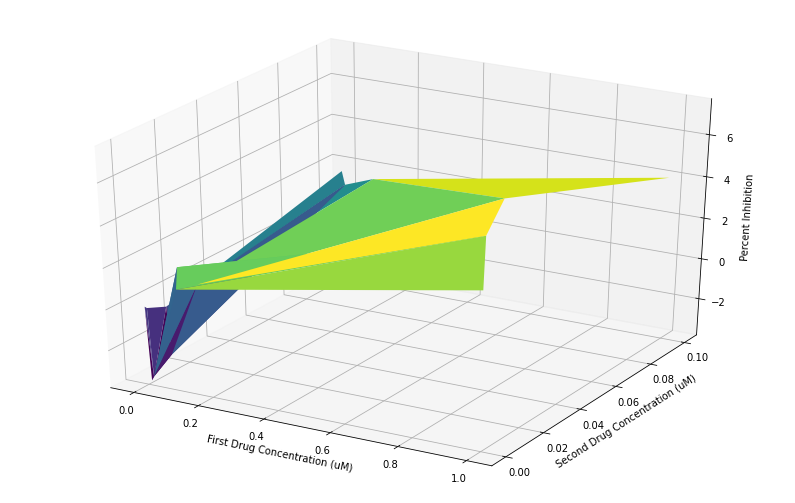

In [213]:
plot(alm_raw[alm_raw['block_id'] == 132369])

In [223]:
def plot_inhib_raw(plot_mode):
    best_synergy_df = comb[comb['study_name'] == 'ALMANAC'].sort_values('synergy_zip', ascending=False).iloc[:20]
    for block_id in best_synergy_df['block_id']:
        plot(alm_raw[alm_raw['block_id'] == block_id], plot_mode=plot_mode, use_log=True)

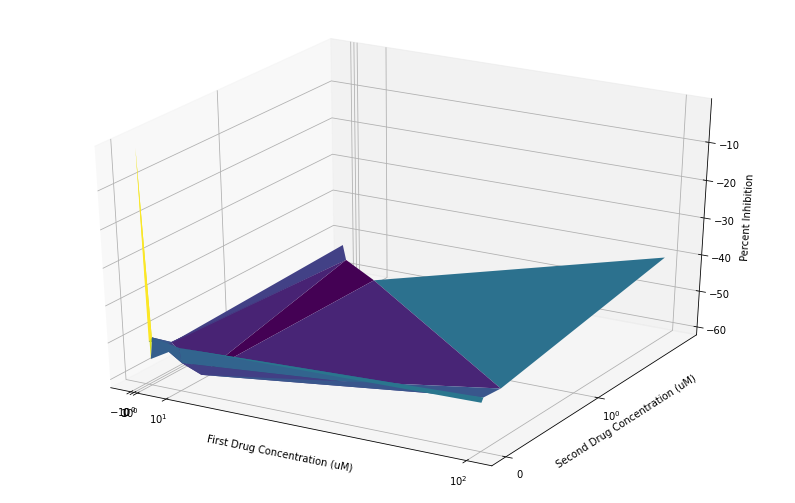

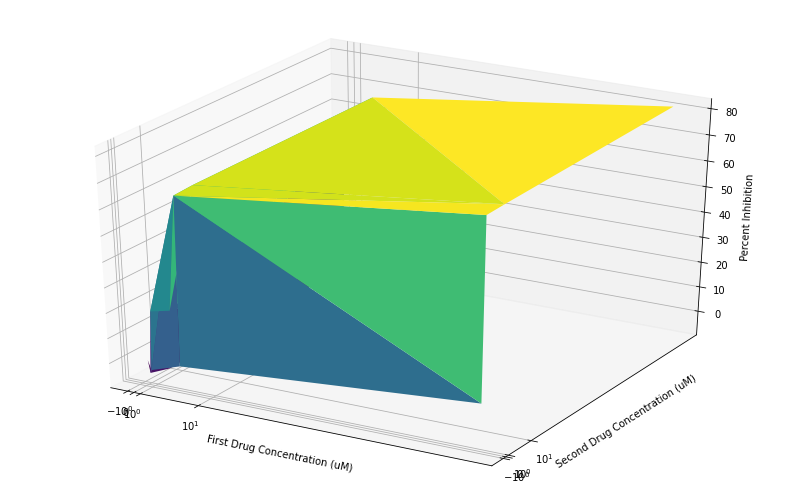

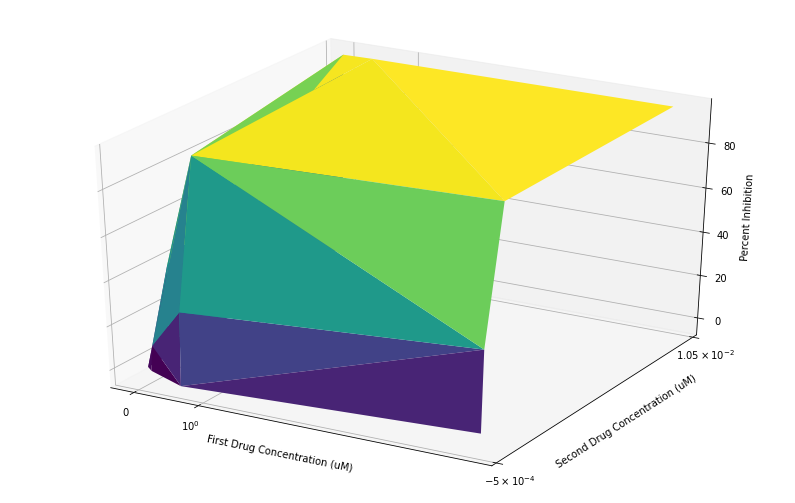

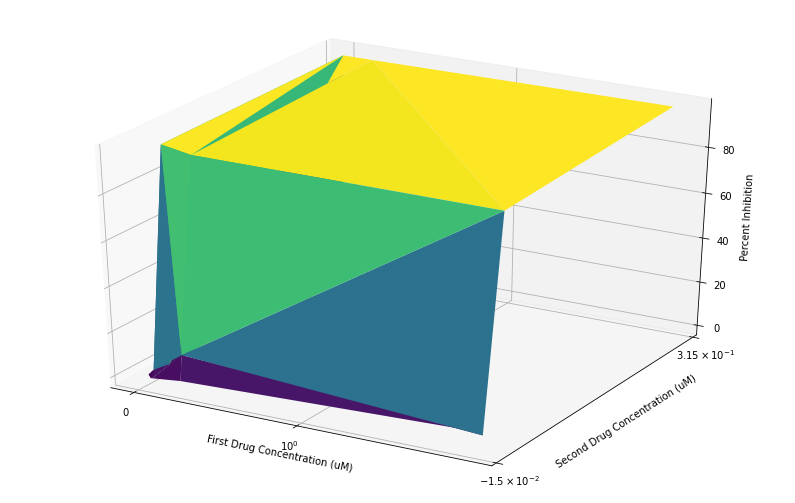

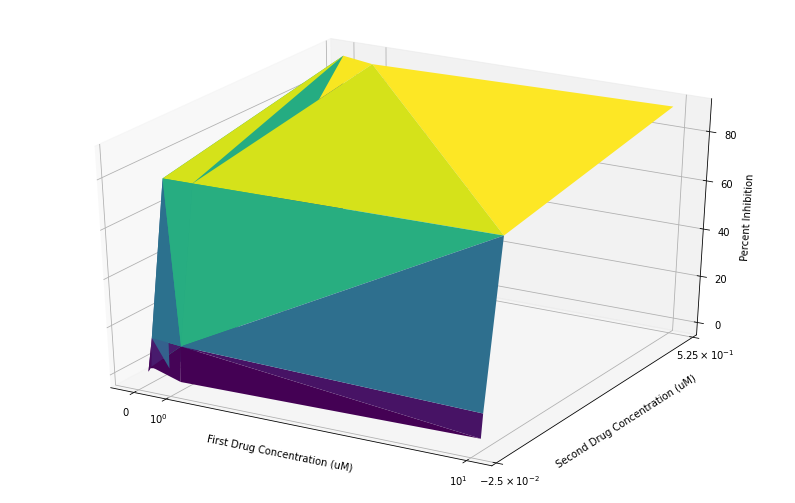

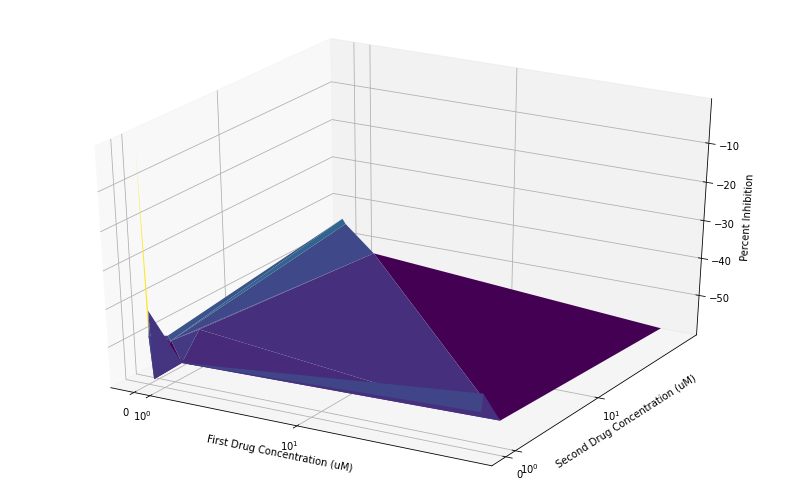

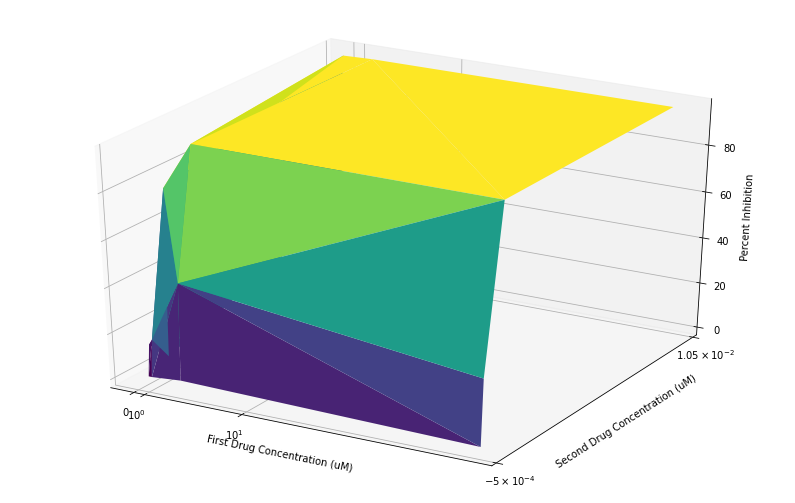

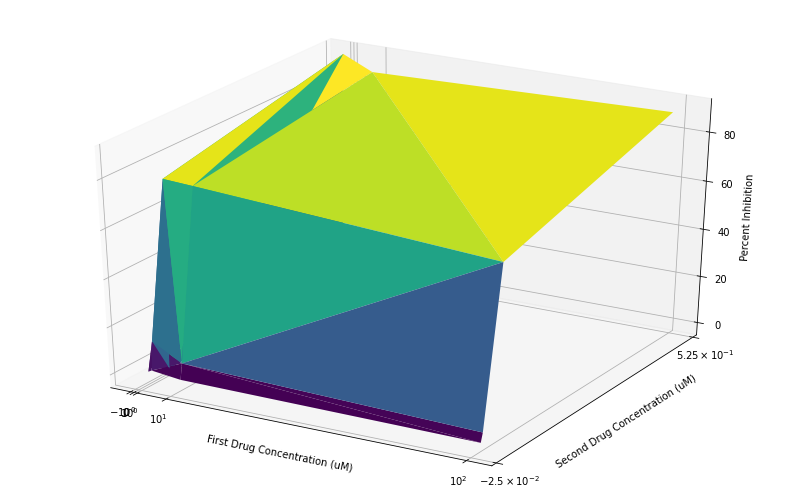

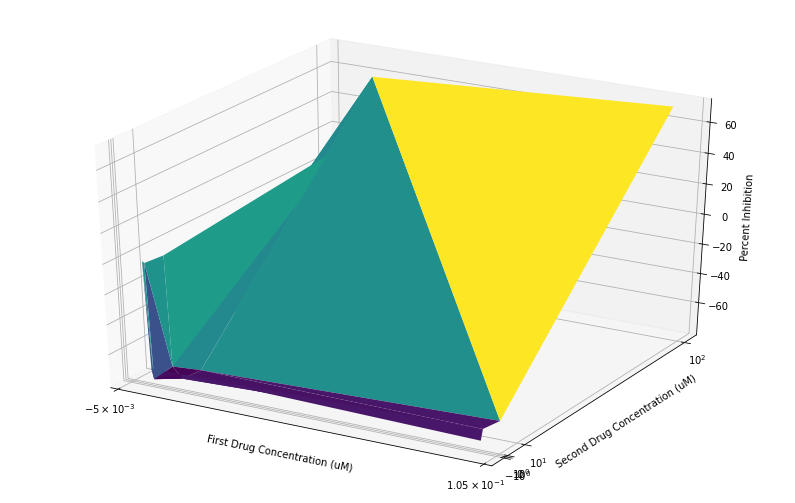

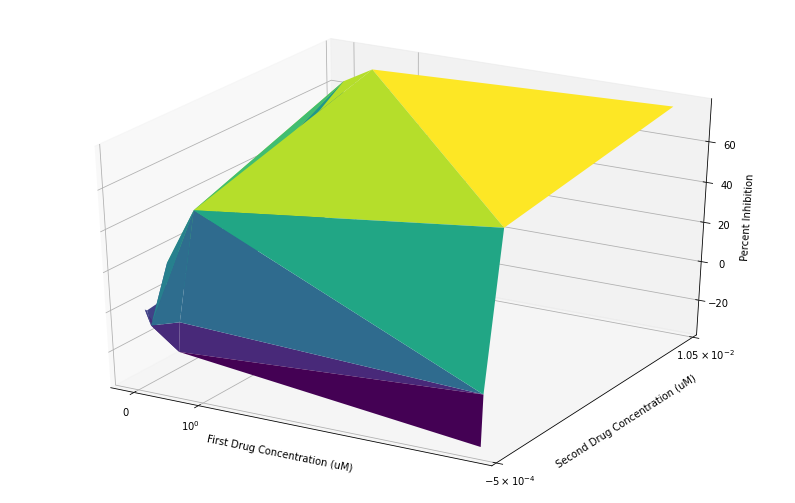

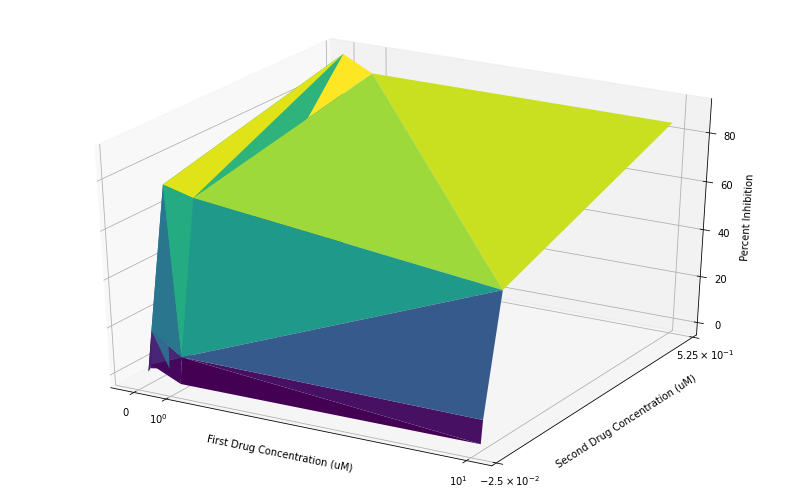

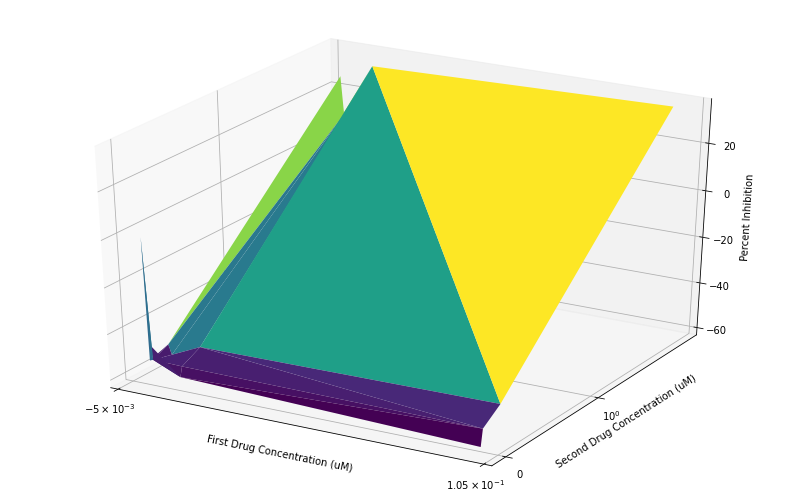

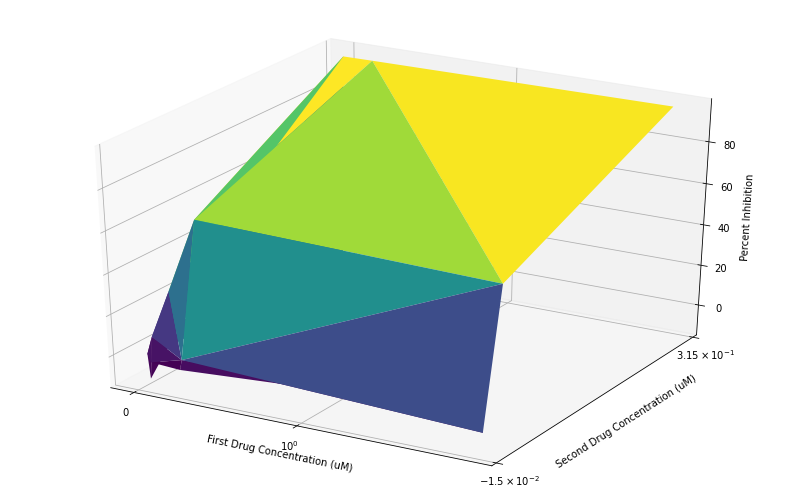

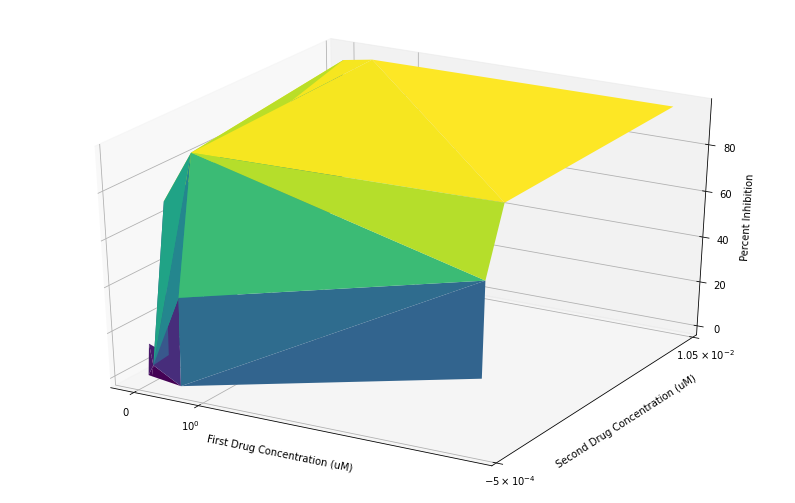

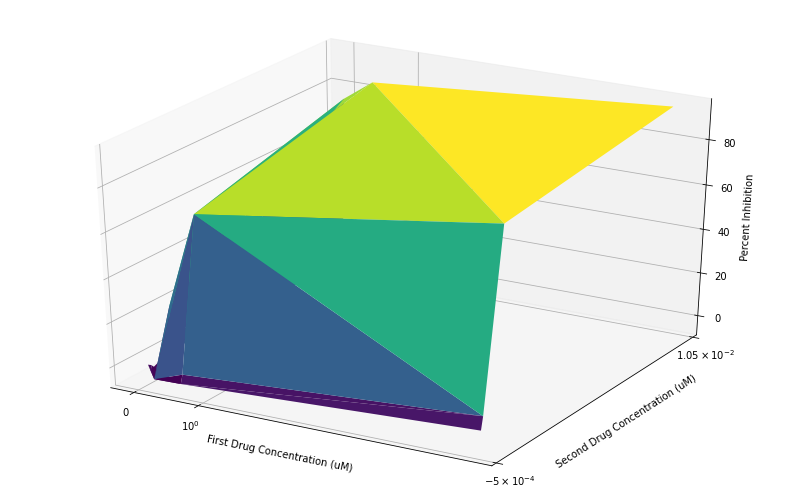

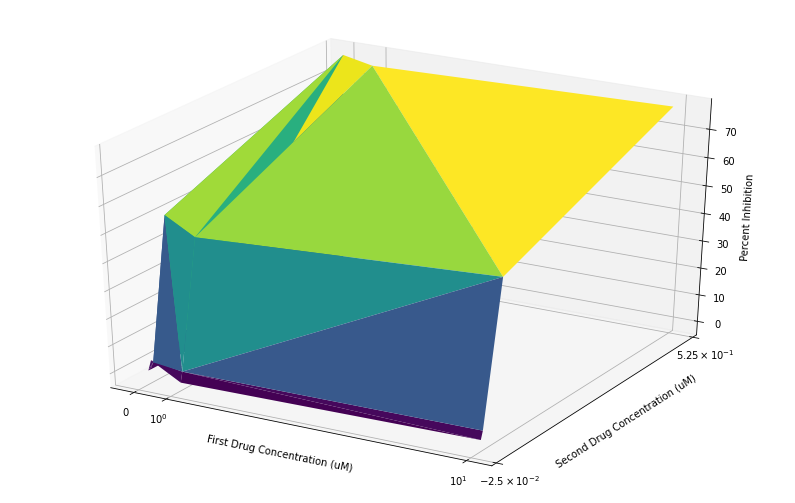

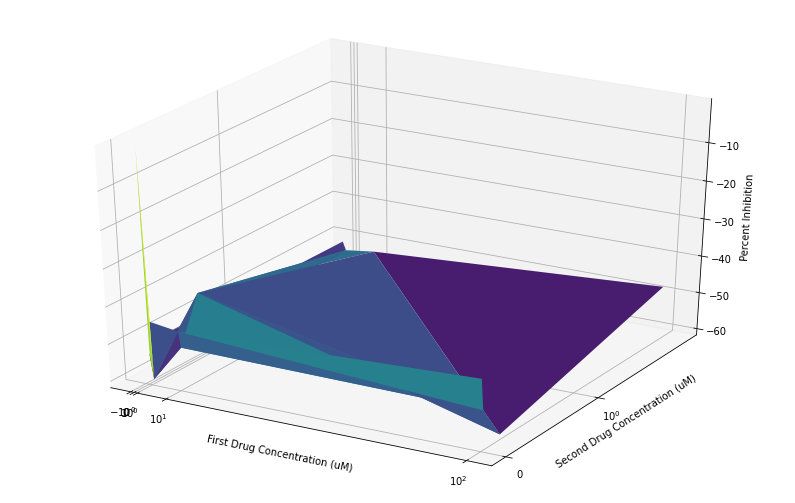

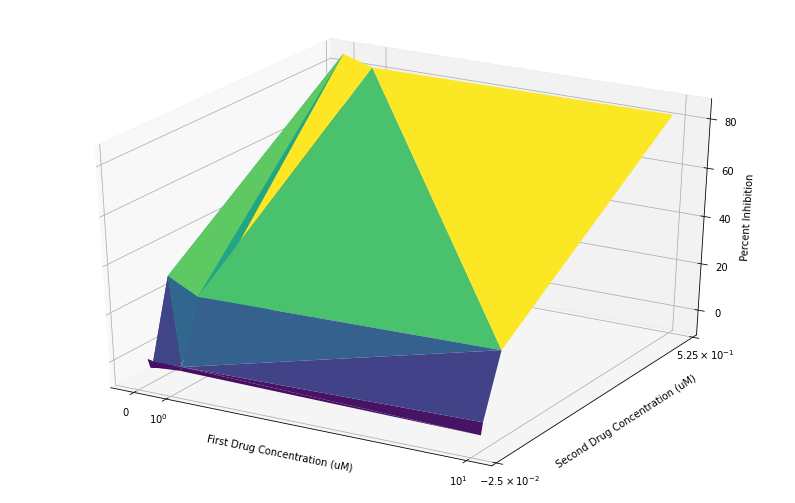

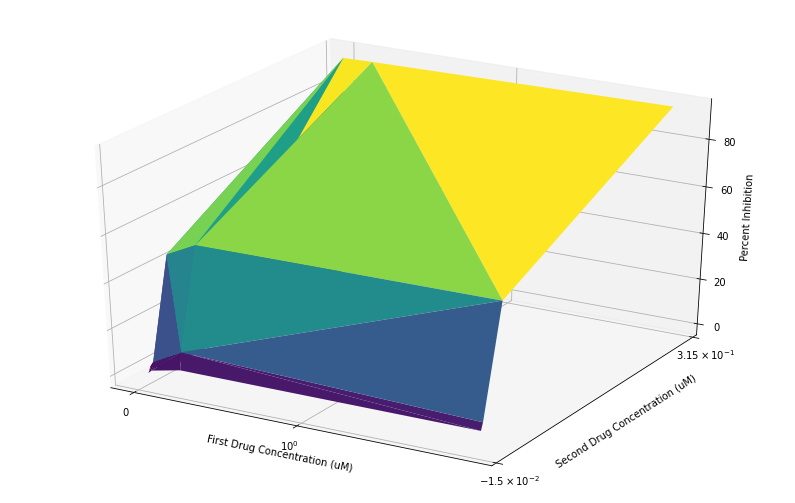

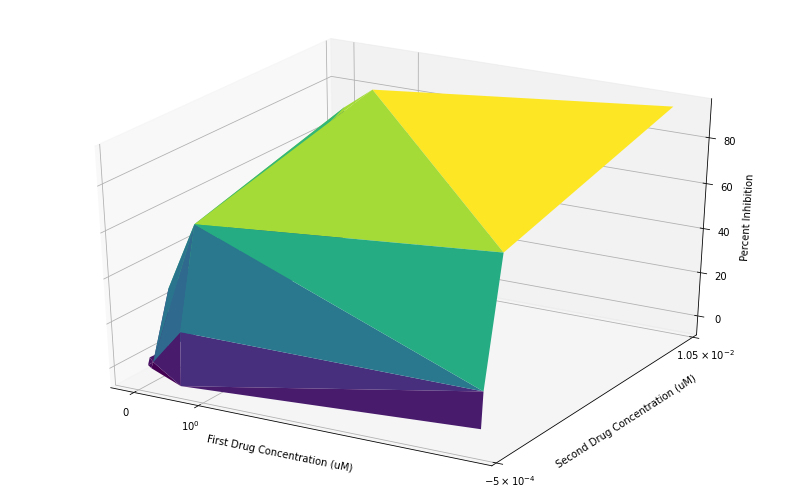

In [225]:
plot_inhib_raw('surf')

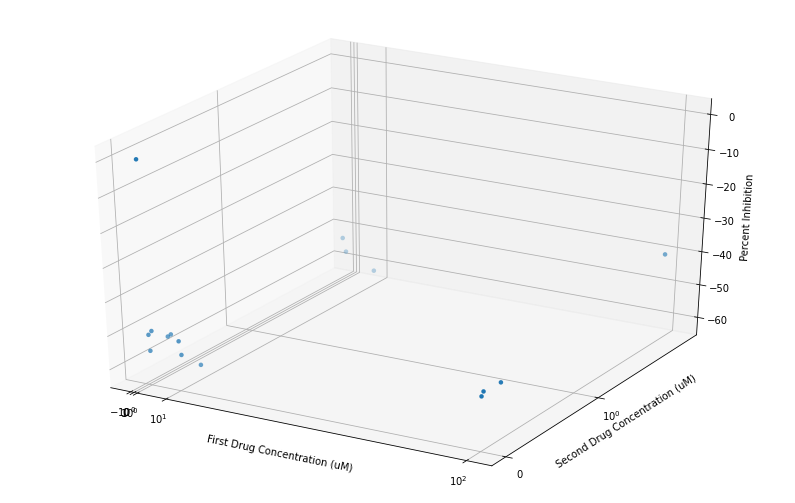

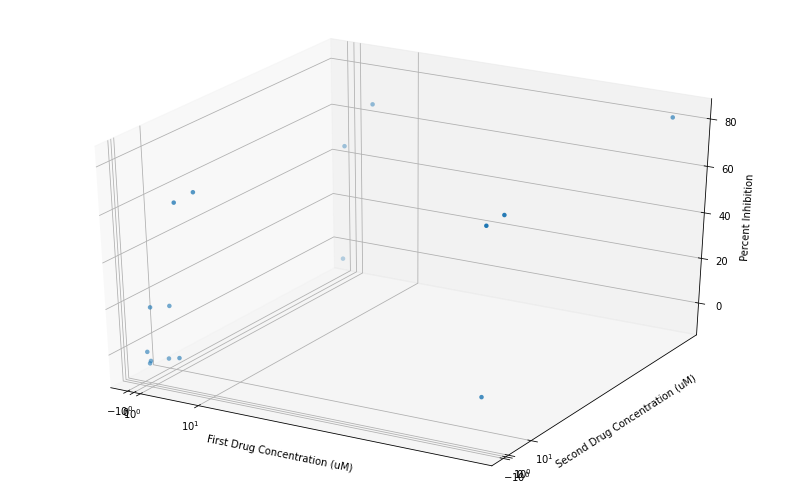

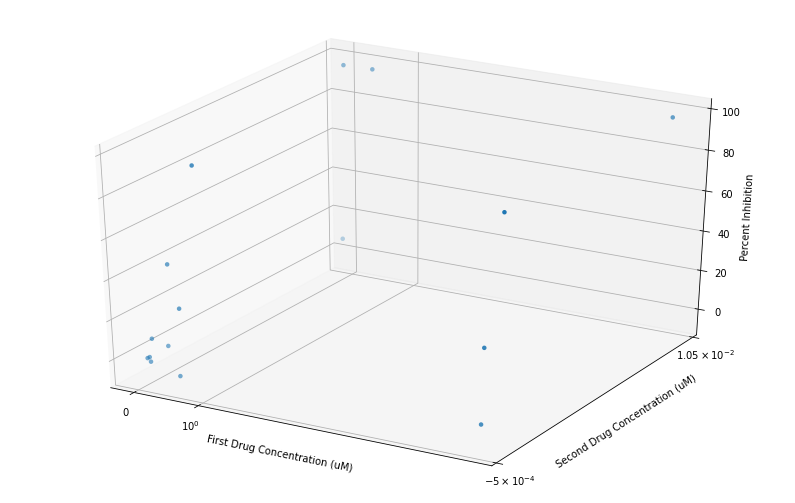

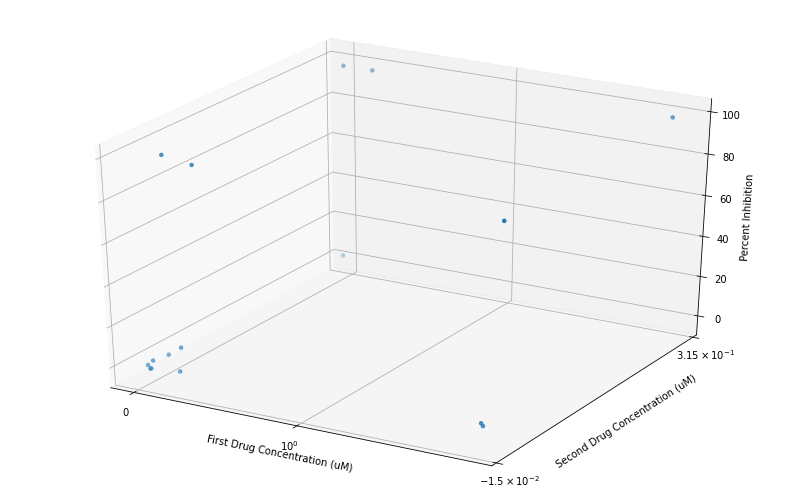

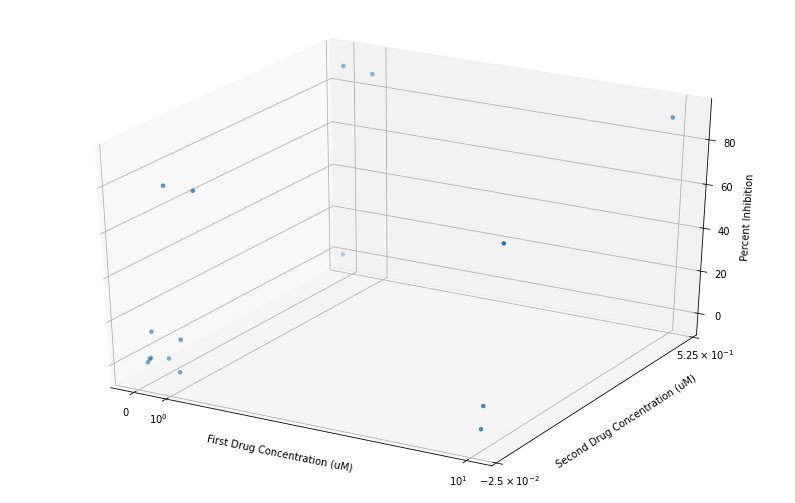

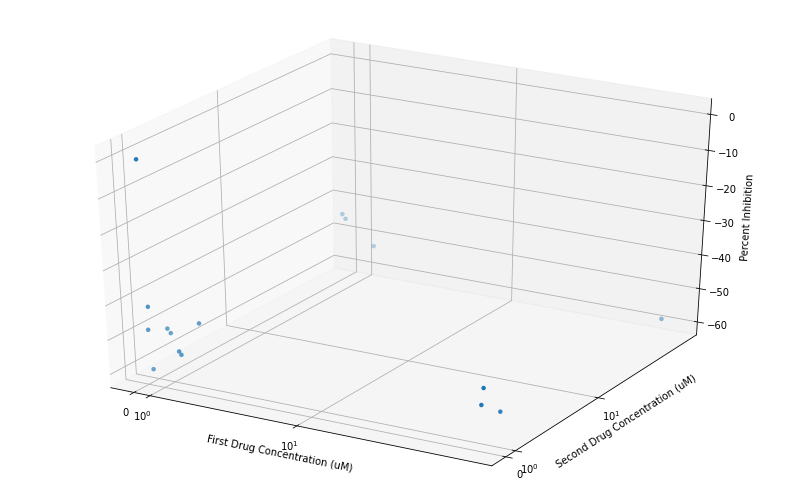

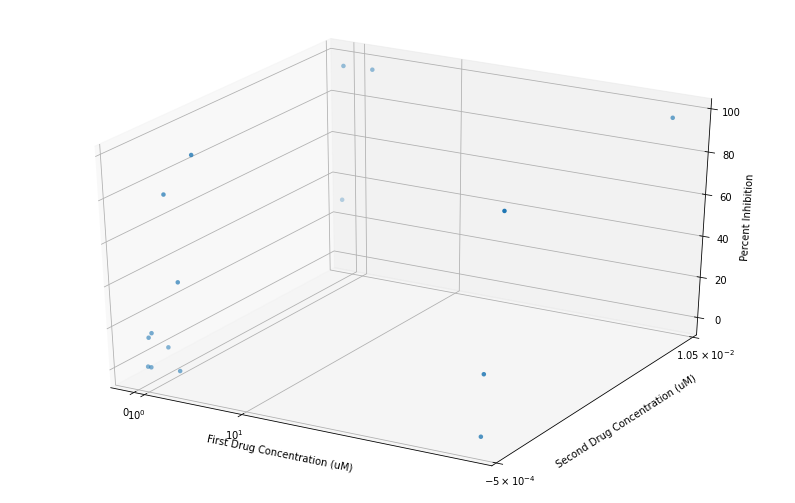

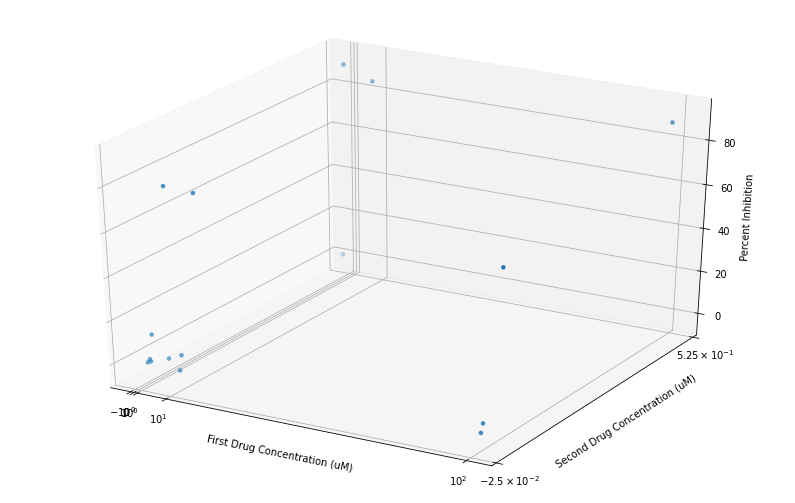

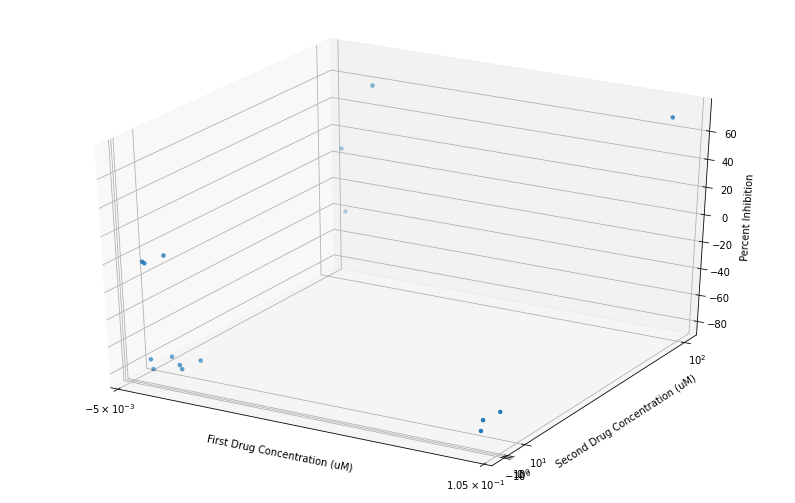

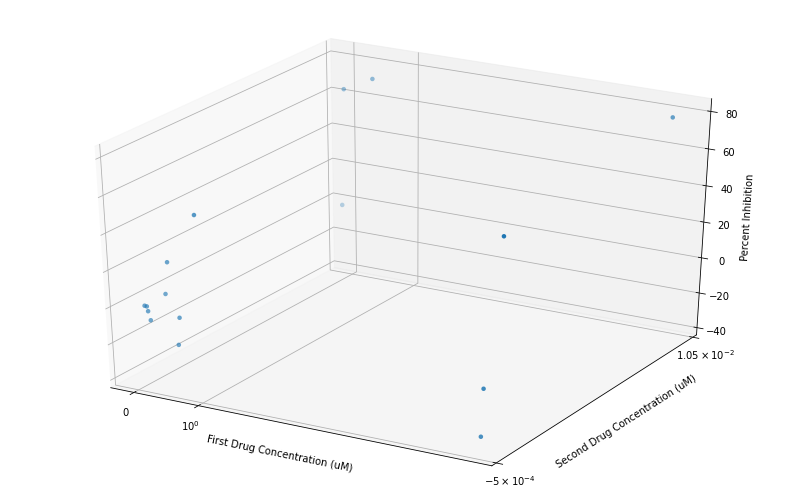

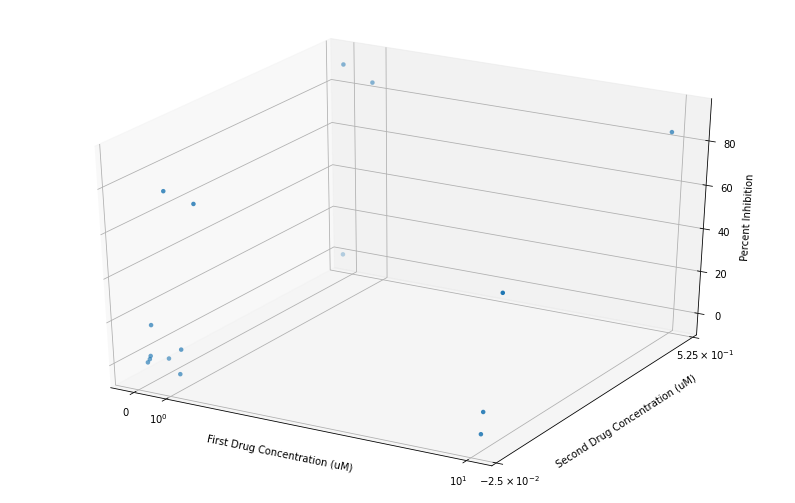

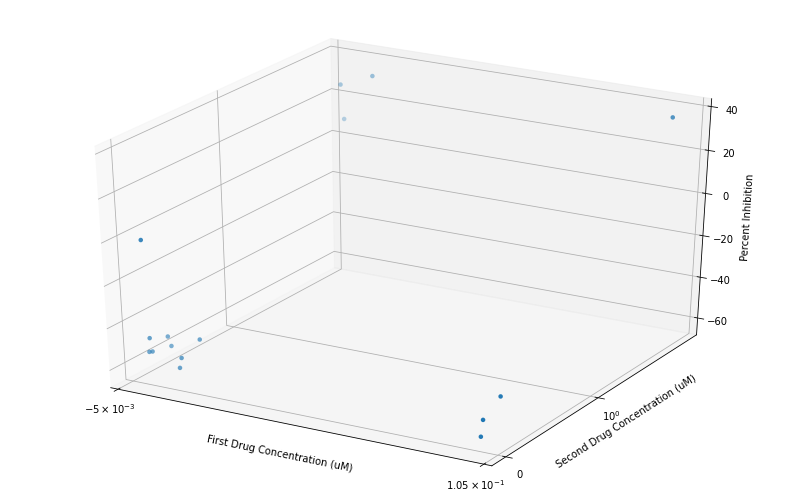

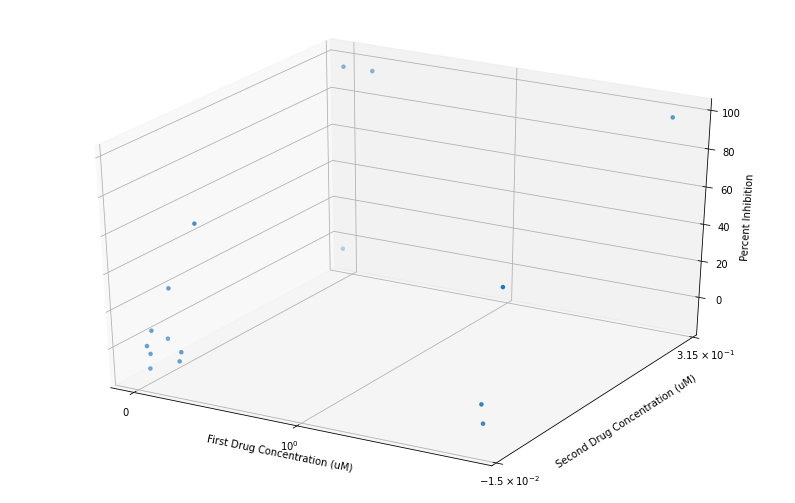

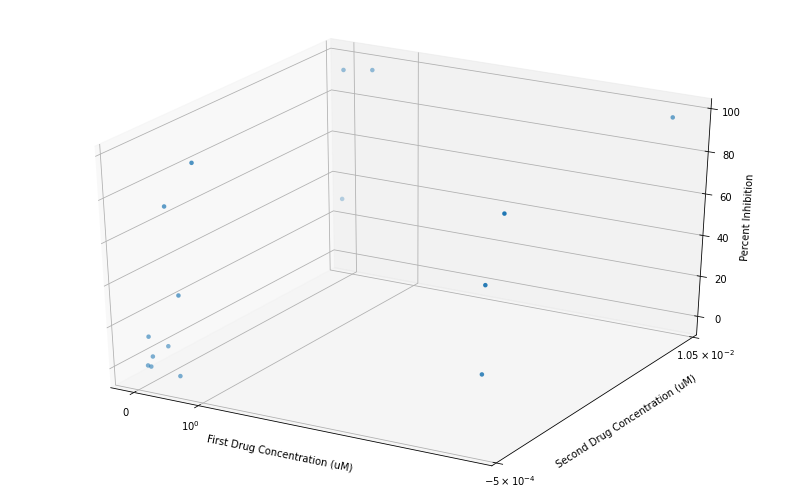

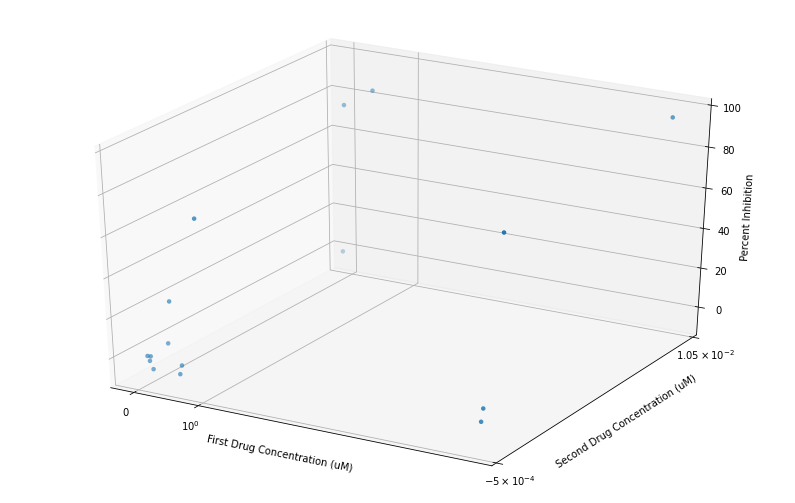

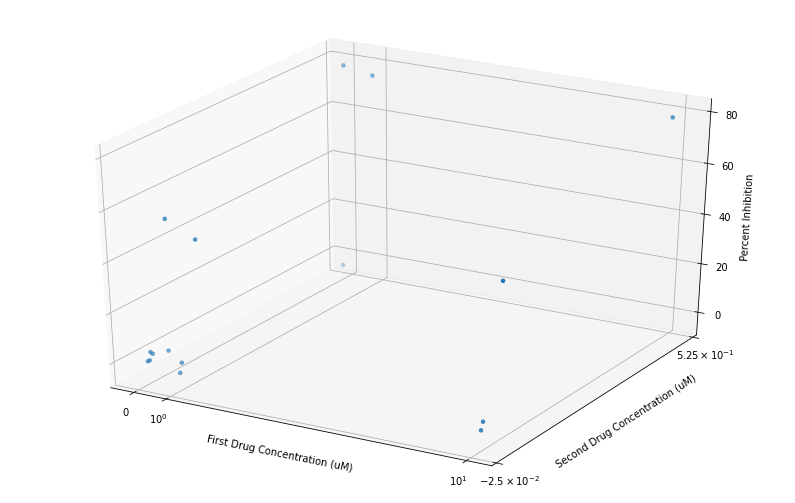

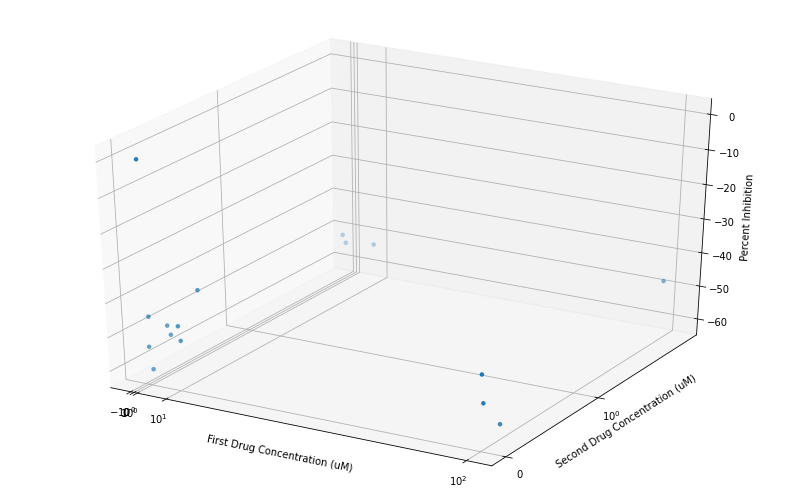

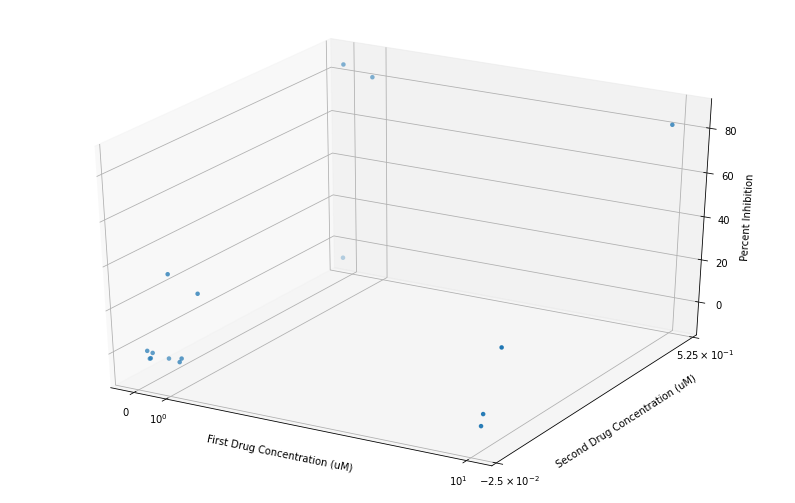

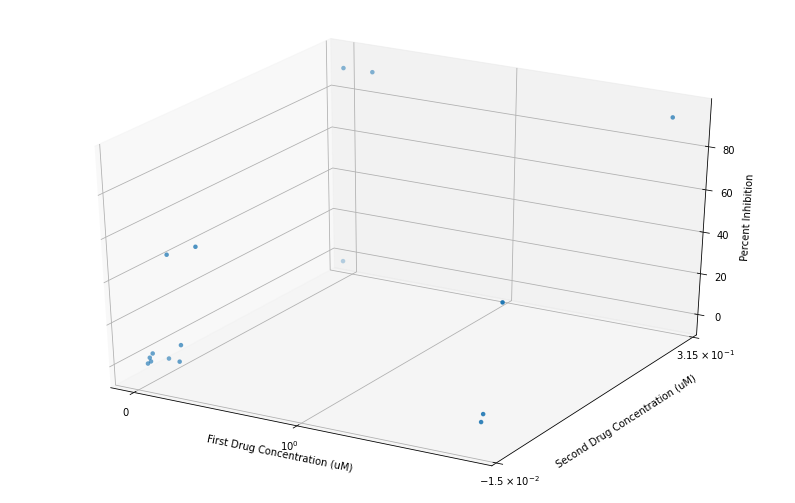

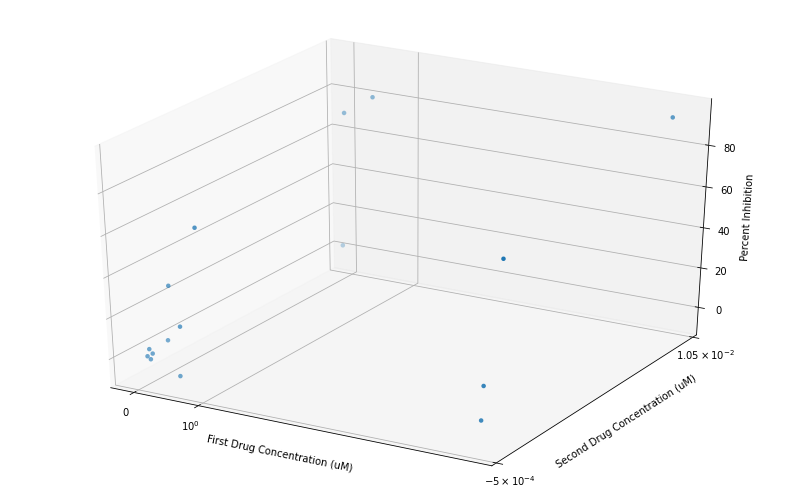

In [226]:
plot_inhib_raw('scatter')

In [161]:
alm_comb = comb[comb['study_name'] == 'ALMANAC']

In [162]:
alm_comb

,block_id,drug_row,drug_col,cell_line_name,conc_r_unit,conc_c_unit,css,synergy_zip,synergy_bliss,synergy_loewe,synergy_hsa,ic50_row,ic50_col,ri_row,ri_col,css_row,css_col,S,study_name
132368,132369,CYTARABINE HYDROCHLORIDE,NSC733504,NCI-H226,uM,uM,1.8875,-0.672451,1.101240,-0.256734,0.066454,0.098297,0.047535,0.368,0.009,2.620,1.155,1.5105,ALMANAC
132369,132370,MERCAPTOPURINE,ANTIBIOTIC AY 22989,K-562,uM,uM,-2.9650,0.669423,-0.251519,-4.418428,-4.495244,0.064536,0.008603,-0.478,-0.035,-2.650,-3.280,-2.4520,ALMANAC
132370,132371,MITOMYCINE,ELOXATIN (TN) (SANOFI SYNTHELAB),CCRF-CEM,uM,uM,31.7185,-1.876969,-6.028172,-16.570355,-6.434438,0.016146,0.612643,-0.126,35.634,34.191,29.246,-3.7895,ALMANAC
132371,132372,CHEMBL17639,IXABEPILONE,MDA-MB-468,uM,uM,40.4065,0.086083,0.542944,-9.737466,1.353194,0.615271,0.017238,2.523,41.909,36.316,44.497,-4.0255,ALMANAC
132372,132373,CYTARABINE HYDROCHLORIDE,ARSENIC TRIOXIDE,IGROV1,uM,uM,60.0760,-2.884889,-1.378867,3.111169,4.660007,1.000000,6.000000,13.038,34.090,72.178,47.974,12.9480,ALMANAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443967,443968,THIOTEPA,NSC256439,UACC-257,uM,uM,48.6010,-2.498196,-0.496971,-9.450995,2.588018,18.498165,0.349457,5.344,24.922,66.907,30.295,18.3350,ALMANAC
443968,443969,EMCYT (PHARMACIA),NSC256439,NCI-H322M,uM,uM,52.1270,0.720398,7.759613,-13.147066,6.813285,45.304225,0.901791,-0.622,11.993,74.102,30.152,40.7560,ALMANAC
443969,443970,GEMZAR (LILLY),ADM HYDROCHLORIDE,NCI-H460,uM,uM,52.6070,-7.370724,-10.310260,-5.126442,-4.344666,0.002869,0.046308,56.786,49.706,53.034,52.180,-53.8850,ALMANAC
443970,443971,TOPOTECAN HYDROCHLORIDE,ADM HYDROCHLORIDE,NCI-H460,uM,uM,51.6585,-5.474909,-12.171414,-12.145725,-8.915631,0.012910,0.046308,34.179,49.706,51.973,51.344,-32.2265,ALMANAC


In [172]:
name = 'nilotinib'.upper()
((alm_comb['drug_row'] == name) | (alm_comb['drug_col'] == name)).sum()

6077

In [201]:
match_row = alm_comb[alm_comb['drug_row'] == name]
match = match_row[match_row['drug_col'] == 'PACLITAXEL']
match.sort_values('synergy_zip', ascending=False)
match[match['cell_line_name'] == 'MCF7']

,block_id,drug_row,drug_col,cell_line_name,conc_r_unit,conc_c_unit,css,synergy_zip,synergy_bliss,synergy_loewe,synergy_hsa,ic50_row,ic50_col,ri_row,ri_col,css_row,css_col,S,study_name
248354,248355,NILOTINIB,PACLITAXEL,MCF7,uM,uM,24.242,0.479794,4.494021,-27.219668,-2.605554,1.0,0.3,-7.113,10.945,35.795,12.689,20.41,ALMANAC


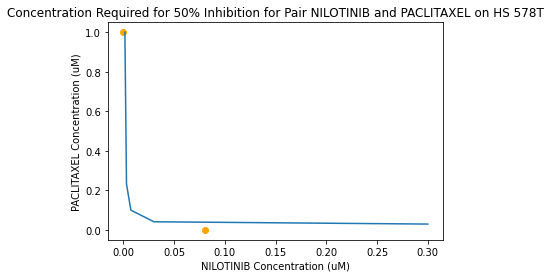

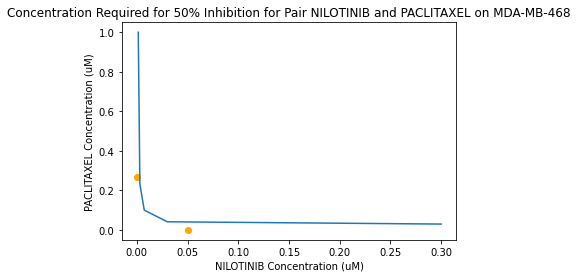

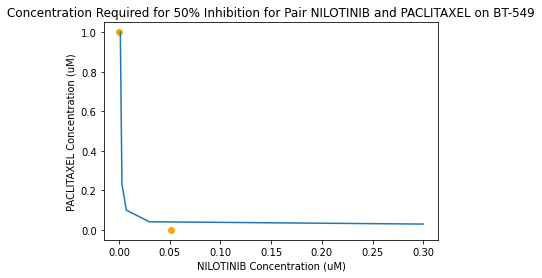

In [195]:
good_line_block_ids = [172225, 274070, 174917]

for bi in good_line_block_ids:
    plot_contour(bi)


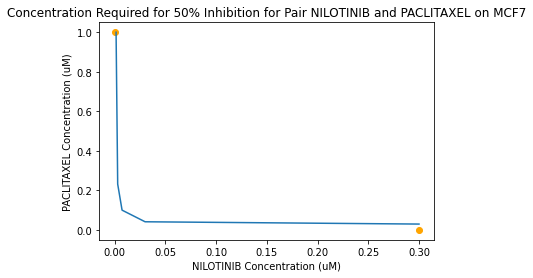

In [198]:
bad_lines_block_idx = [248355, 239681]

for bi in bad_lines_block_idx:
    plot_contour(bi)